**CHALLENGE 3 PROTEIN**

**IMPORT**

In [1]:
import sys
import numpy as np
import keras
from keras.utils import Sequence
from PIL import Image
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
import imgaug as ia
from imgaug import augmenters as iaa
import cv2

Using TensorFlow backend.


**DONNEE**

In [2]:
BATCH_SIZE = 16 #découpe
SEED = 777
SHAPE = (512, 512, 4)
DIR = 'Data/Challenge3'

**SEUIL DE VALIDATION**

In [ ]:
VAL_RATIO = 0.1 # 10 % de validation
THRESHOLD = 0.5 # seuil de probabilité de prédire que l'image appartient à la classe

ia.seed(SEED)

In [3]:
#on recupere les données d'entrainement
def getTrainDataset():
    
    path_to_train = DIR + '/train/'
    data = pd.read_csv(DIR + '/train.csv')

    paths = []
    labels = []
    
    for name, lbl in zip(data['Id'], data['Target'].str.split(' ')):
        y = np.zeros(28)
        for key in lbl:
            y[int(key)] = 1
        paths.append(os.path.join(path_to_train, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

#on recupere les données Test 
def getTestDataset():
    
    path_to_test = DIR + '/test/'
    data = pd.read_csv(DIR + '/sample_submission.csv')

    paths = []
    labels = []
    
    for name in data['Id']:
        y = np.ones(28)
        paths.append(os.path.join(path_to_test, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

In [4]:
class ProteinDataGenerator(keras.utils.Sequence):
            
    def __init__(self, paths, labels, batch_size, shape, shuffle = False, use_cache = False, augment = False):
        self.paths, self.labels = paths, labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.use_cache = use_cache
        self.augment = augment
        if use_cache == True:
            self.cache = np.zeros((paths.shape[0], shape[0], shape[1], shape[2]), dtype=np.float16)
            self.is_cached = np.zeros((paths.shape[0]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]

        paths = self.paths[indexes]
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
        if self.use_cache == True:
            X = self.cache[indexes]
            for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                image = self.__load_image(path)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
        else:
            for i, path in enumerate(paths):
                X[i] = self.__load_image(path)

        y = self.labels[indexes]
                
        if self.augment == True:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5), 
                    iaa.Crop(percent=(0, 0.1)), 
                  
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.ContrastNormalization((0.75, 1.5)),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])], random_order=True)

            X = np.concatenate((X, seq.augment_images(X), seq.augment_images(X), seq.augment_images(X)), 0)
            y = np.concatenate((y, y, y, y), 0)
        
        return X, y
    
    
    def on_epoch_end(self):
        
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

            
    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            yield item
            
            
    def __load_image(self, path):
        R = Image.open(path + '_red.png')
        G = Image.open(path + '_green.png')
        B = Image.open(path + '_blue.png')
        Y = Image.open(path + '_yellow.png')

        im = np.stack((
            np.array(R), 
            np.array(G), 
            np.array(B),
            np.array(Y)), -1)
        
        im = cv2.resize(im, (SHAPE[0], SHAPE[1]))
        im = np.divide(im, 255)
        return im

**KERAS**

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, ReLU, LeakyReLU, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import metrics
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import keras
import tensorflow as tf

from tensorflow import set_random_seed
set_random_seed(SEED)

In [6]:
#f1 : Fonction de validation, prediction valide

def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

#f1_loss : Fonction de perte, mauvaise prediction

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1-K.mean(f1)

**CREATION DU MODEL**

In [7]:
def create_model(input_shape):
    
    dropRate = 0.25
    
    init = Input(input_shape)
    x = BatchNormalization(axis=-1)(init)
    x = Conv2D(32, (3, 3))(x) #, strides=(2,2))(x)
    x = ReLU()(x)

    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    ginp1 = Dropout(dropRate)(x)
    
    x = BatchNormalization(axis=-1)(ginp1)
    x = Conv2D(64, (3, 3), strides=(2,2))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(64, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(64, (3, 3))(x)
    x = ReLU()(x)
    
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    ginp2 = Dropout(dropRate)(x)
    
    x = BatchNormalization(axis=-1)(ginp2)
    x = Conv2D(128, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(128, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(128, (3, 3))(x)
    x = ReLU()(x)
    ginp3 = Dropout(dropRate)(x)
    
    gap1 = GlobalAveragePooling2D()(ginp1)
    gap2 = GlobalAveragePooling2D()(ginp2)
    gap3 = GlobalAveragePooling2D()(ginp3)
    
    x = Concatenate()([gap1, gap2, gap3])
    
    x = BatchNormalization(axis=-1)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropRate)(x)
    
    x = BatchNormalization(axis=-1)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    x = Dense(28)(x)
    x = Activation('sigmoid')(x)
    
    model = Model(init, x)
    
    return model

In [8]:
model = create_model(SHAPE)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-03),
    metrics=['acc',f1])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 4)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 4)  16          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 510, 510, 32) 1184        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 510, 510, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [14]:
paths, labels = getTrainDataset()

keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(SEED)
np.random.shuffle(keys)
lastTrainIndex = int((1-VAL_RATIO) * paths.shape[0])

pathsTrain = paths[0:lastTrainIndex]
labelsTrain = labels[0:lastTrainIndex]
pathsVal = paths[lastTrainIndex:]
labelsVal = labels[lastTrainIndex:]

#image et vecteur label
print(paths.shape, labels.shape)

#image entrainé et vecteur labe, image avec prediction du bon label
print(pathsTrain.shape, labelsTrain.shape, pathsVal.shape, labelsVal.shape)

tg = ProteinDataGenerator(pathsTrain, labelsTrain, BATCH_SIZE, SHAPE, use_cache=False, augment = False, shuffle = False)
vg = ProteinDataGenerator(pathsVal, labelsVal, BATCH_SIZE, SHAPE, use_cache=False, shuffle = False)

checkpoint = ModelCheckpoint('./base.model', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min')

(31072,) (31072, 28)
(27964,) (27964, 28) (3108,) (3108, 28)


**ENTRAINEMENT DU MODEL**

In [10]:
epochs = 4
#20

use_multiprocessing = False 
workers = 1 

hist = model.fit_generator(
    tg,
    steps_per_epoch=len(tg),
    validation_data=vg,
    validation_steps=8,
    epochs=epochs,
    use_multiprocessing=use_multiprocessing,
    workers=workers,
    verbose=1,
    callbacks=[checkpoint])

#f1 : Fonction de validation, prediction valide
#f1_loss : Fonction de perte, mauvaise prediction


Epoch 1/4
1748/1748 [==============================] - 2153s 1s/step - loss: 0.1695 - acc: 0.9444 - f1: 0.0703 - val_loss: 0.1609 - val_acc: 0.9467 - val_f1: 0.0860

Epoch 00001: val_loss improved from inf to 0.16095, saving model to ./base.model
Epoch 2/4
1748/1748 [==============================] - 2153s 1s/step - loss: 0.1478 - acc: 0.9495 - f1: 0.0950 - val_loss: 0.1379 - val_acc: 0.9523 - val_f1: 0.1083

Epoch 00002: val_loss improved from 0.16095 to 0.13789, saving model to ./base.model
Epoch 3/4
1748/1748 [==============================] - 2147s 1s/step - loss: 0.1353 - acc: 0.9525 - f1: 0.1189 - val_loss: 0.1412 - val_acc: 0.9551 - val_f1: 0.1335

Epoch 00003: val_loss did not improve from 0.13789
Epoch 4/4
1748/1748 [==============================] - 2178s 1s/step - loss: 0.1228 - acc: 0.9567 - f1: 0.1493 - val_loss: 0.1139 - val_acc: 0.9595 - val_f1: 0.1635

Epoch 00004: val_loss improved from 0.13789 to 0.11391, saving model to ./base.model


**VALIDATION**

Choisir le seuil de prédiction approprié maximisant le score de validation F1

In [15]:
bestModel = load_model('./base.model', custom_objects={'f1': f1})

In [16]:
fullValGen = vg

In [17]:
from sklearn.metrics import f1_score as off1

def getOptimalT(mdl, fullValGen):
    
    lastFullValPred = np.empty((0, 28))
    lastFullValLabels = np.empty((0, 28))
    for i in tqdm(range(len(fullValGen))): 
        im, lbl = fullValGen[i]
        scores = mdl.predict(im)
        lastFullValPred = np.append(lastFullValPred, scores, axis=0)
        lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
    print(lastFullValPred.shape, lastFullValLabels.shape)
    
    rng = np.arange(0, 1, 0.001)
    f1s = np.zeros((rng.shape[0], 28))
    for j,t in enumerate(tqdm(rng)):
        for i in range(28):
            p = np.array(lastFullValPred[:,i]>t, dtype=np.int8)
            scoref1 = off1(lastFullValLabels[:,i], p, average='binary')
            f1s[j,i] = scoref1
            
    print(np.max(f1s, axis=0))
    print(np.mean(np.max(f1s, axis=0)))
    
    plt.plot(rng, f1s)
    T = np.empty(28)
    for i in range(28):
        T[i] = rng[np.where(f1s[:,i] == np.max(f1s[:,i]))[0][0]]
    #print('Choosing threshold: ', T, ', validation F1-score: ', max(f1s))
    print(T)
    
    return T, np.mean(np.max(f1s, axis=0))

  0%|          | 0/195 [00:00<?, ?it/s]

Last model after fine-tuning


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
  0%|          | 4/1000 [00:00<00:31, 32.01it/s]

(3108, 28) (3108, 28)


  5%|▍         | 48/1000 [00:01<00:29, 32.40it/s]/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 1000/1000 [00:29<00:00, 34.78it/s]


[0.80767811 0.72727273 0.7053701  0.4556962  0.72148541 0.49094567
 0.37634409 0.53832442 0.25       0.4        0.30769231 0.43946188
 0.39766082 0.4        0.79365079 0.01058201 0.08333333 0.38709677
 0.30088496 0.33882353 0.14285714 0.59541985 0.42328042 0.68987342
 0.27027027 0.64632153 0.19642857 0.        ]
0.42488408352848284
[0.622 0.232 0.345 0.203 0.57  0.196 0.247 0.208 0.062 0.081 0.064 0.16
 0.198 0.385 0.137 0.002 0.053 0.062 0.111 0.095 0.151 0.418 0.205 0.447
 0.296 0.515 0.053 0.   ]


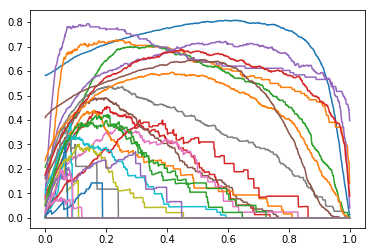

In [18]:
fullValGen = ProteinDataGenerator(paths[lastTrainIndex:], labels[lastTrainIndex:], BATCH_SIZE, SHAPE)
T1, ff1 = getOptimalT(model, fullValGen)

  0%|          | 0/195 [00:00<?, ?it/s]

Best save model


  0%|          | 4/1000 [00:00<00:30, 32.73it/s]

(3108, 28) (3108, 28)


100%|██████████| 1000/1000 [00:29<00:00, 34.63it/s]


[0.80767811 0.72727273 0.7053701  0.4556962  0.72148541 0.49094567
 0.37634409 0.53832442 0.25       0.4        0.30769231 0.43946188
 0.39766082 0.4        0.79365079 0.01058201 0.08333333 0.38709677
 0.30088496 0.33882353 0.14285714 0.59541985 0.42328042 0.68987342
 0.27027027 0.64632153 0.19642857 0.        ]
0.42488408352848284
[0.622 0.232 0.345 0.203 0.57  0.196 0.247 0.208 0.062 0.081 0.064 0.16
 0.198 0.385 0.137 0.002 0.053 0.062 0.111 0.095 0.151 0.418 0.205 0.447
 0.296 0.515 0.053 0.   ]


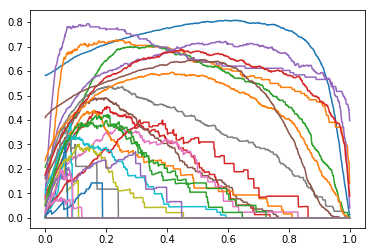

In [19]:
print('Best save model')
T2, ff2 = getOptimalT(bestModel, fullValGen)

In [20]:
if ff1 > ff2:
    T = T1
    bestModel = model
else:
    T = T2
    bestModel = bestModel

In [21]:
pathsTest, labelsTest = getTestDataset()

testg = ProteinDataGenerator(pathsTest, labelsTest, BATCH_SIZE, SHAPE)
submit = pd.read_csv(DIR + '/sample_submission.csv')
P = np.zeros((pathsTest.shape[0], 28))
for i in tqdm(range(len(testg))):
    images, labels = testg[i]
    score = bestModel.predict(images)
    P[i*BATCH_SIZE:i*BATCH_SIZE+score.shape[0]] = score

100%|██████████| 732/732 [17:14<00:00,  1.06s/it]


In [22]:
PP = np.array(P)

**RESULTAT**

In [23]:
prediction = []

for row in tqdm(range(submit.shape[0])):
    
    str_label = ''
    
    for col in range(PP.shape[1]):
        if(PP[row, col] < T[col]):
            str_label += ''
        else:
            str_label += str(col) + ' '
    prediction.append(str_label.strip())
    
submit['Predicted'] = np.array(prediction)
submit.to_csv('result.csv', index=False)

100%|██████████| 11702/11702 [00:00<00:00, 55761.09it/s]


Score : O,283